In [1]:
import numpy as np
from PIL import Image
import os
import random
import matplotlib.pyplot as plt

In [21]:
def crop_memory(memory, image_size, box_size, fill_value=0):
    memory = memory.reshape(image_size)
    cropped_memory = np.full(image_size, fill_value)
    start_index = (image_size[0] - box_size[0]) // 2
    end_index = start_index + box_size[0]
    cropped_memory[start_index:end_index, start_index:end_index] = \
        memory[start_index:end_index, start_index:end_index]
    return cropped_memory.flatten()

In [4]:
def initialize_weight_matrix(neurons_num, training_data):
    # Initialize the weight matrix with zeros
    weight_matrix = np.zeros((neurons_num, neurons_num))

    # Initialize the weight matrix using Hebbian Learning
    for pattern in training_data:
        pattern = pattern.reshape((-1, 1))
        weight_matrix = weight_matrix + np.dot(pattern, pattern.T)

    weight_matrix /= len(training_data)

    return weight_matrix

In [5]:
def load_training_data(folder_path):
    # This is an empty list which we will use to store the training patterns (PBM images as binary vectors)
    training_data = []

    # Iterating over all the files in our workpics folder
    for pbm_file in os.listdir(folder_path):
        if pbm_file.endswith(".pbm"):
            # Check if the file extension is correct
            file_path = os.path.join(folder_path, pbm_file)

            # Opening and adding it to the training dataset list
            with Image.open(file_path) as img:
                img = img.resize((60, 60), Image.LANCZOS)
                img = img.convert('L')

                binary_vector = np.array(img).flatten()

                # To make the image into "light" and "dark" pattern. (Threshold = 128)
                binary_vector[binary_vector < 128] = 0
                binary_vector[binary_vector >= 128] = 1

                # Finally append the vector to the training data set.
                training_data.append(binary_vector)

    return training_data

In [6]:
def save_network_state_as_pbm(state, file_path, image_size):
    binary_state = state.astype(np.uint8) * 255
    binary_state = binary_state.reshape(image_size)
    img = Image.fromarray(binary_state, mode='L')
    img.save(file_path)

In [7]:
def corrupt_initial_state(initial_state, corruption_prob):
    corrupted_state = initial_state.copy()
    for i in range(len(initial_state)):
        if random.random() < corruption_prob:
            corrupted_state[i] = 1 - corrupted_state[i]
    return corrupted_state

In [78]:
def sync_simulation(training_data, num_iterations, output_folder, p, save_interval=1):
    neurons_num = training_data[0].shape[0]

    # Initialize weight matrix (you need to implement this)
    weight_matrix = initialize_weight_matrix(neurons_num, training_data)
    
    # Choose a random initial state
    initial_state = random.choice(training_data).copy()
    
    # Corrupt the initial state with probability p (you need to implement this)
    initial_state = corrupt_initial_state(initial_state, p)
    
    # Perform Hopfield Network updates and save states midway
    for i in range(num_iterations):
        activations = np.dot(weight_matrix, initial_state)
        
        # Apply your threshold function here
        new_state = (activations >= 0.5).astype(int)
        
        # Save the current state as a PBM image at specified intervals
        if i % 1 == 0:
            output_path = os.path.join(output_folder, 'sync_states', f'state_{i}.pbm')
            save_network_state_as_pbm(initial_state, output_path, (60, 60))
        
        # Update the state for the next iteration
        initial_state = new_state

    print("Synchronous Hopfield Network updates completed.")

In [97]:
def synchronous_simulation_cropped(training_data, num_iterations, output_folder):
    neurons_num = training_data[0].shape[0]

    # Initialize the weight matrix
    weight_matrix = initialize_weight_matrix(neurons_num, training_data)

    # Create an initial state for the Hopfield Network
    initial_state = random.choice(training_data).copy()
    
    initial_state = crop_memory(initial_state, (60, 60), (40, 40), fill_value=0)

    # Perform synchronous Hopfield Network updates with cropping and save states midway
    for i in range(num_iterations):
        neuron_index = random.randint(0, neurons_num - 1)
        activation = np.dot(weight_matrix[neuron_index, :], initial_state)
        new_state = 1 if activation >= 0.5 else 0

        # Update the selected neuron's state
        initial_state[neuron_index] = new_state

        # Save the current state as a PBM image midway
        if i % 500 == 0:
            output_path = os.path.join(output_folder, 'sync_cropped', f'state_{i}.pbm')
            save_network_state_as_pbm(initial_state, output_path, (60, 60))

    print("Synchronous Hopfield Network updates with cropping completed.")

In [26]:
def async_simulation(training_data, num_iterations, output_folder, p):
    neurons_num = training_data[0].shape[0]  #3600

    weight_matrix = initialize_weight_matrix(neurons_num, training_data)
    initial_state = random.choice(training_data).copy()
    
    ##corrupt
    initial_state = corrupt_initial_state(initial_state, p)
    
    for i in range(num_iterations):
        neuron_index = random.randint(0, neurons_num - 1)
        activation = np.dot(weight_matrix[neuron_index, :], initial_state)
        new_state = 1 if activation >= 0.5 else 0
        
        if i % 500 == 0:
            output_path = os.path.join(output_folder, 'async_states',f'state_{i}.pbm')
            save_network_state_as_pbm(initial_state, output_path, (60, 60))
        
        initial_state[neuron_index] = new_state
        

    print("Hopfield Network updates completed ASYNCRONOUSLY.")

In [58]:
def asynchronous_simulation_cropped(training_data, num_iterations, output_folder):
    neurons_num = training_data[0].shape[0]

    # Initialize the weight matrix
    weight_matrix = initialize_weight_matrix(neurons_num, training_data)
    
    initial_state = random.choice(training_data).copy()
    
    # Create an initial state for the Hopfield Network
    initial_state = crop_memory(initial_state, (60, 60), (40, 40), fill_value=0)

    # Perform asynchronous Hopfield Network updates with cropping and save states midway
    for i in range(num_iterations):
        neuron_index = random.randint(0, neurons_num - 1)
        activation = np.dot(weight_matrix[neuron_index, :], initial_state)
        new_state = 1 if activation >= 0.5 else 0
        
        # Save the current state as a PBM image midway
        if i % 500 == 0:
            output_path = os.path.join(output_folder, "async_cropped",f'state_{i}.pbm')
            save_network_state_as_pbm(initial_state, output_path, (60, 60))
        
        # Update the selected neuron's state asynchronously
        initial_state[neuron_index] = new_state

    print("Asynchronous Hopfield Network updates with cropping completed.")

In [98]:
# Path to the PBM pictures
folderPath = "workpics"

# Number of iterations for updating the network
numIterations = 15000

#Corruption Prob
p = 0.3

# Create an output folder for saving the states
outputFolder = "network_states"
os.makedirs(outputFolder, exist_ok=True)
os.makedirs(os.path.join(outputFolder, 'async_states'), exist_ok=True)
os.makedirs(os.path.join(outputFolder, 'sync_states'), exist_ok=True)
os.makedirs(os.path.join(outputFolder, 'sync_cropped'), exist_ok=True)
os.makedirs(os.path.join(outputFolder, 'async_cropped'), exist_ok=True)

In [18]:
trainingData = load_training_data(folderPath)

In [79]:
sync_simulation(trainingData, numIterations, outputFolder, p)

Synchronous Hopfield Network updates completed.


In [99]:
synchronous_simulation_cropped(trainingData, numIterations, outputFolder)

Synchronous Hopfield Network updates with cropping completed.


In [27]:
async_simulation(trainingData, numIterations, outputFolder, p)

Hopfield Network updates completed ASYNCRONOUSLY.


In [85]:
asynchronous_simulation_cropped(trainingData, numIterations, outputFolder)

Asynchronous Hopfield Network updates with cropping completed.


In [100]:
def display_image(i):
    path = f"./network_states/sync_cropped/state_{i}.pbm"
    # Open the image file
    img = Image.open(path)

    # Display the image
    plt.imshow(img)
    plt.show()

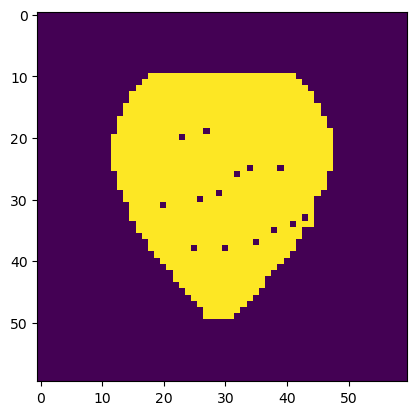

In [101]:
display_image(0)

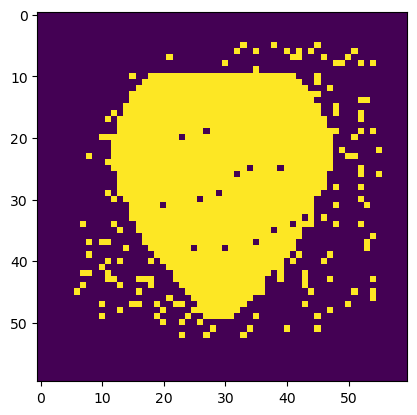

In [102]:
display_image(500)

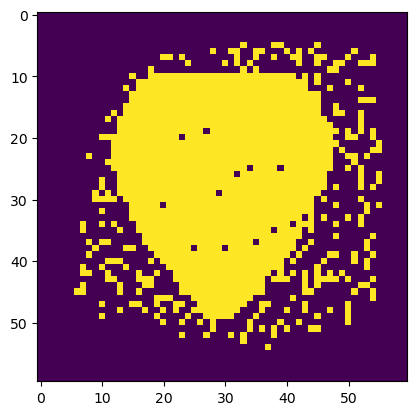

In [103]:
display_image(1000)

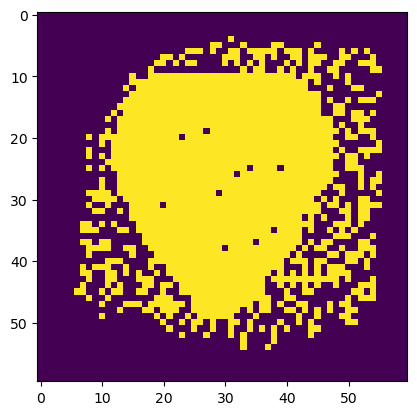

In [104]:
display_image(2000)

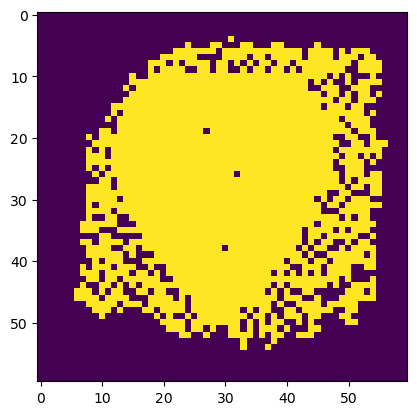

In [105]:
display_image(4000)

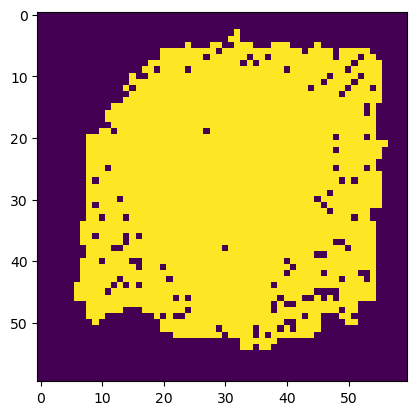

In [106]:
display_image(8000)

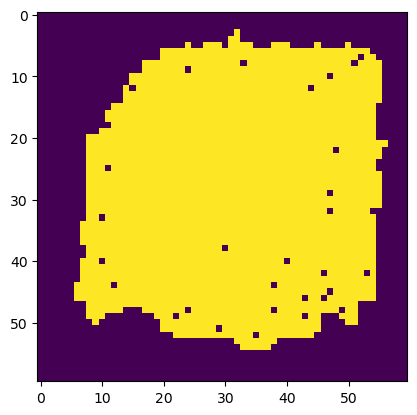

In [107]:
display_image(12000)

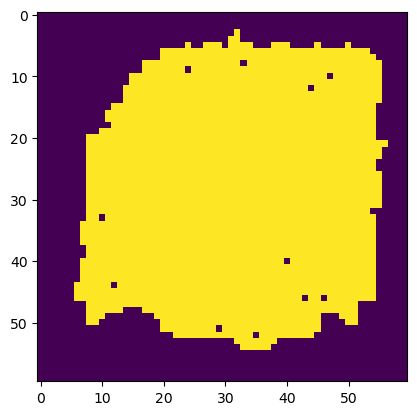

In [108]:
display_image(14500)